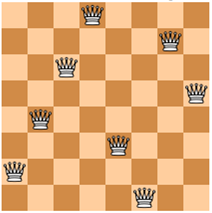

## Cromossomo

### Binário:
[001 011 101 111 010 110 100]

### Real:
[1 3 5 7 2 0 6 4]


In [23]:
import numpy as np
import random
from deap import creator, base, tools, algorithms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import pandas as pd


In [25]:
#N = Número de rainhas
N = 8
#log_N = número de bits para representar cada rainha
log_N = int(np.log2(N))


#Funções extraídas do código original do livro
#https://github.com/aimacode/aima-python
def conflicted(state, row, col):
    """Would placing a queen at (row, col) conflict with anything?"""
    return any(conflict(row, col, state[c], c)
               for c in range(col))

def conflict(row1, col1, row2, col2):
    """Would putting two queens in (row1, col1) and (row2, col2) conflict?"""
    return (row1 == row2 or  # same row
            col1 == col2 or  # same column
            row1 - col1 == row2 - col2 or  # same \ diagonal
            row1 + col1 == row2 + col2)  # same / diagonal

def goal_test(state):
    """Check if all columns filled, no conflicts."""
    if state[-1] == -1:
        return False
    return not any(conflicted(state, state[col], col)
                   for col in range(len(state)))

def h(node):
    """Return number of conflicting queens for a given node"""
    num_conflicts = 0
    for (r1, c1) in enumerate(node):
        for (r2, c2) in enumerate(node):
            if (r1, c1) != (r2, c2):
                num_conflicts += conflict(r1, c1, r2, c2)
    return num_conflicts

def nqueen_fitness(node):
    node_int = []
    for i in range(0, len(node), log_N):
        a = map(str, node[i:i+log_N])    
        val = int(''.join(a), 2)
        node_int.append(val % N)  # Garante que está entre 0 e N-1

    return h(node_int),

    
def plot_solution(solution, N):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim((0, N))
    ax.set_ylim((0, N))

    count = 0
    for queen in solution:
        ax.add_patch(patches.Rectangle((queen, count), 1, 1))
        count += 1
    plt.show()

In [26]:
def setup_creator_toolbox(N):
    log_N = int(np.log2(N))

    # Evita erro se já tiver sido criado
    if "Fitness" in creator.__dict__:
        del creator.Fitness
    if "Individual" in creator.__dict__:
        del creator.Individual

    creator.create("Fitness", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.Fitness)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=N*log_N)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", nqueen_fitness)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=11)

    return toolbox, log_N


In [27]:
def run_genetic_nqueens(N, ngen=50, pop_size=500, cxpb=0.8, mutpb=0.05, runs=5):
    results = []
    toolbox, log_N = setup_creator_toolbox(N)

    for run in range(runs):
        population = toolbox.population(n=pop_size)
        start = time.time()

        # Avalia indivíduos
        fits = toolbox.map(toolbox.evaluate, population)
        for fit, ind in zip(fits, population):
            ind.fitness.values = fit

        avg_list, top_list, worst_list = [], [], []

        for gen in range(ngen):
            offspring = algorithms.varAnd(population, toolbox, cxpb=cxpb, mutpb=mutpb)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            population[:] = offspring

            avg = np.mean([ind.fitness.values[0] for ind in population])
            top = min([ind.fitness.values[0] for ind in population])
            worst = max([ind.fitness.values[0] for ind in population])
            avg_list.append(avg)
            top_list.append(top)
            worst_list.append(worst)

            if top == 0:
                break

        end = time.time()
        best = tools.selBest(population, 1)[0]
        best_fitness = nqueen_fitness(best)[0]
        solved = (best_fitness == 0)
        exec_time = end - start

        results.append({
            "N": N,
            "Run": run + 1,
            "Solved": solved,
            "Fitness": best_fitness,
            "Time": exec_time,
            "AvgHistory": avg_list,
            "TopHistory": top_list,
            "WorstHistory": worst_list,
            "BestIndividual": best
        })

    return results, log_N



Executando algoritmo genético para N=32
Run 1: Solved=False | Fitness=384 | Time=32.44s
Run 2: Solved=False | Fitness=388 | Time=32.43s
Run 3: Solved=False | Fitness=390 | Time=32.37s
Run 4: Solved=False | Fitness=386 | Time=50.54s
Run 5: Solved=False | Fitness=390 | Time=49.34s


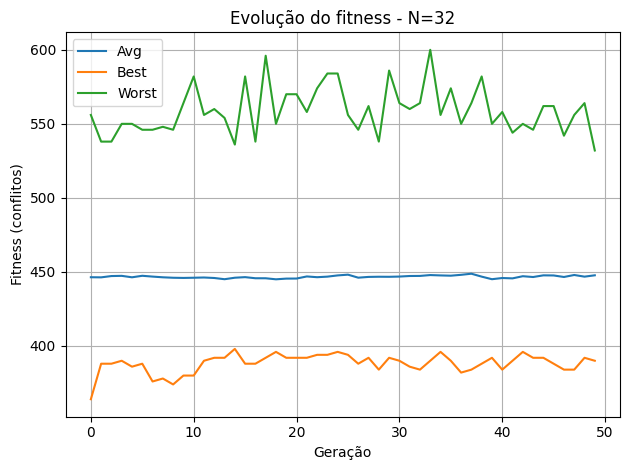


Executando algoritmo genético para N=64
Run 1: Solved=False | Fitness=248 | Time=98.66s
Run 2: Solved=False | Fitness=254 | Time=57.33s
Run 3: Solved=False | Fitness=242 | Time=48.08s
Run 4: Solved=False | Fitness=238 | Time=44.88s
Run 5: Solved=False | Fitness=248 | Time=47.84s


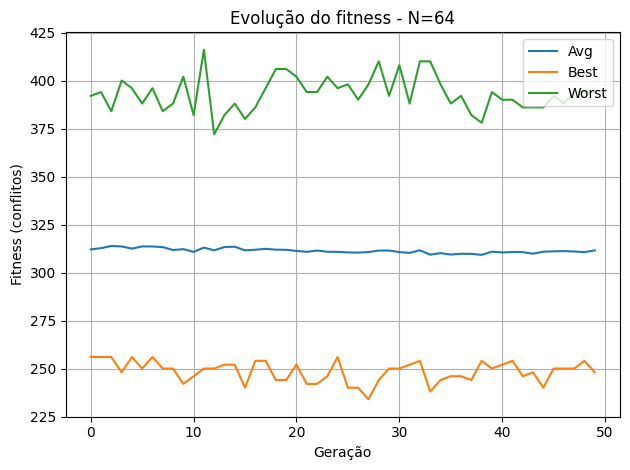


Executando algoritmo genético para N=128
Run 1: Solved=False | Fitness=518 | Time=171.06s
Run 2: Solved=False | Fitness=510 | Time=182.20s
Run 3: Solved=False | Fitness=514 | Time=181.00s
Run 4: Solved=False | Fitness=506 | Time=247.71s
Run 5: Solved=False | Fitness=500 | Time=175.07s


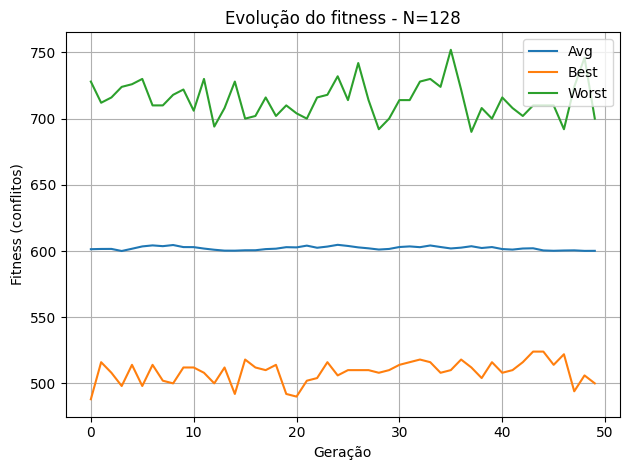

In [28]:
all_results = []

for N in [32, 64, 128]:
    print(f"\nExecutando algoritmo genético para N={N}")
    results, log_N = run_genetic_nqueens(N)

    for r in results:
        print(f"Run {r['Run']}: Solved={r['Solved']} | Fitness={r['Fitness']} | Time={r['Time']:.2f}s")
        all_results.append(r)

    # Plot do último run
    plt.plot(r['AvgHistory'], label='Avg')
    plt.plot(r['TopHistory'], label='Best')
    plt.plot(r['WorstHistory'], label='Worst')
    plt.title(f"Evolução do fitness - N={N}")
    plt.xlabel("Geração")
    plt.ylabel("Fitness (conflitos)")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"fitness_N{N}.png")
    plt.show()


In [34]:
df_results = pd.DataFrame([{
    "N": r["N"],
    "Run": r["Run"],
    "Solved": r["Solved"],
    "Fitness": r["Fitness"],
    "Time (s)": r["Time"]
} for r in all_results])

df_results


,N,Run,Solved,Fitness,Time (s)
0,32,1,False,384,32.436987
1,32,2,False,388,32.426581
2,32,3,False,390,32.366861
3,32,4,False,386,50.541873
4,32,5,False,390,49.338129
5,64,1,False,248,98.663372
6,64,2,False,254,57.328413
7,64,3,False,242,48.079320
8,64,4,False,238,44.883102
9,64,5,False,248,47.837756
